# Neural Networks for Data Science Applications
## Final Homework: Putting everything together

**Name**: Daniele Trappolini

**Matricola**: 1710415

For model and others kind of file please refer to my google drive folder: https://drive.google.com/drive/folders/1p2dn4kAzYKBbjv8RQ-c0GH2Obdt-OviC?usp=sharing

## LIBRARY

In [ ]:
!pip install -q gwpy  # it's a tool that avoid the long intermidiate results thanks to %%capture

ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
%%capture
!pip install tf-nightly

In [ ]:
%%capture
from google.colab import files
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img
from google.colab import drive
from PIL import Image
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

## PREPROCESSING DATA

LOADING DATASET:

I've used this kind of preprocessing because in origin i didn't know if that would be my final dataset and so I've created a general preprocessing that could work for more or less all kind of dataset. Infact this passage is not required for this dataset because it is also presents in tf.datasets. 

The preprocessing steps: 

*   I dowloaded the whole datasets from http://madm.dfki.de/files/sentinel/EuroSAT.zip 
*   The zip folder is composed with other subfolder each subfolder represent a different label. 
*   I uploaded the dataset on google drive in order to have an easy access on colab. 
*  With the function unzip I unzip this dataset 
*  I saved the label name with the function os.listdir that allow me to save the folder name
*  Finally I apply tf.keras.preprocessing.image_dataset_from_directory that is a function that is able to handle the dataset with this format.

For more details regarding the dataset and the DL benchmark [EuroSAT: A Novel Dataset and Deep Learning
Benchmark for Land Use and Land Cover
Classification](https://arxiv.org/pdf/1709.00029.pdf)






In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!unzip /content/drive/MyDrive/EuroSAT.zip

In [ ]:
DATASET = '/content/2750'

In [ ]:
LABELS = os.listdir(DATASET)

In [ ]:
LABELS

['Highway',
 'HerbaceousVegetation',
 'River',
 'SeaLake',
 'Residential',
 'Pasture',
 'Forest',
 'Industrial',
 'AnnualCrop',
 'PermanentCrop']

In [ ]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET,
    labels="inferred",
    label_mode="int",
    class_names=LABELS,
    color_mode="rgb",
    batch_size=64,
    image_size=(64, 64),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    follow_links=False,
)

ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET,
    labels="inferred",
    label_mode="int",
    class_names=LABELS,
    color_mode="rgb",
    batch_size=64,
    image_size=(64, 64),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    follow_links=False,
)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [ ]:
ds_train # here we have a dataset composed by batches

<BatchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

Here I apply data augmentation in order to reduce overfitting adding noise in particular using [random_flip_left_right](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right)

In [ ]:
def preprocess(image, label):
    image = tf.image.resize(image, [64,64])
    image = image/255.0
    return image, tf.cast(label, tf.float32)
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label    

In [ ]:
ds_train = ds_train.map(preprocess).map(augment).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
X_train = []
Y_train = []
for images,labels in ds_train.take(len(ds_train)):
  numpy_images = images.numpy()#/255
  numpy_labels = labels.numpy()
  for i in range(len(numpy_images)):
    X_train.append(numpy_images[i])
    Y_train.append(numpy_labels[i])

In [ ]:
x_test = []
y_test = []
for images,labels in ds_val.take(len(ds_val)):
  numpy_images = images.numpy()#/255
  numpy_labels = labels.numpy()
  for i in range(len(numpy_images)):
    x_test.append(numpy_images[i]) 
    y_test.append(numpy_labels[i]) 

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_eval, y_train, y_eval = train_test_split(X_train, Y_train, test_size=0.10, random_state=42) 

In [ ]:
y_train = np.array(y_train)
x_train = np.array(x_train)
y_test = np.array(y_test) 
x_test = np.array(x_test) 
X_eval = np.array(x_eval)   
Y_eval = np.array(y_eval) 

## VISUALIZATION
I use the code for the visualization of the PIL images: [source code](https://note.nkmk.me/en/python-pillow-concat-images/). 

So as you can see through the visualization the dataset is composed by RGB image coming from satellite. This is only a tiny part of the original dataset because the Sentinel 2 provides 13 differents bands in the visible spectrum. And my dataset pick only Red, Green and Blue (B2,B3,B4). It could be an improvement of this project analysis the results with other combinations of bands for instance False color infrared combination(B8,B4,B3). 

In [ ]:
%%capture
pip install matplotlib==3.1.3

In [ ]:
for images, labels in ds_train.take(1):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [ ]:
EX_images = []
for i in range(len(numpy_images)):
  img = numpy_images[i]
  img = array_to_img(img)
  EX_images += [img]

In [ ]:
def get_concat_h_blank(im1, im2, color=(0, 0, 0)):
    dst = Image.new('RGB', (im1.width + im2.width, max(im1.height, im2.height)), color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [ ]:
def get_concat_h_multi_blank(im_list):
    _im = im_list.pop(0)
    for im in im_list:
        _im = get_concat_h_blank(_im, im)
    return _im

In [ ]:
im1 = get_concat_h_multi_blank(EX_images[:8])
im2 = get_concat_h_multi_blank(EX_images[8:16])
im3 = get_concat_h_multi_blank(EX_images[16:24])
im4 = get_concat_h_multi_blank(EX_images[24:32])
im5 = get_concat_h_multi_blank(EX_images[32:40])
im6 = get_concat_h_multi_blank(EX_images[40:48])
im7 = get_concat_h_multi_blank(EX_images[48:56])
im8 = get_concat_h_multi_blank(EX_images[56:64])

EX_images2 = [im1,im2,im3,im4,im5,im6,im7,im8]

In [ ]:
def get_concat_v_blank(im1, im2, color=(0, 0, 0)):
    dst = Image.new('RGB', (max(im1.width, im2.width), im1.height + im2.height), color)
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_v_multi_blank(im_list):
    _im = im_list.pop(0)
    for im in im_list:
        _im = get_concat_v_blank(_im, im)
    return _im

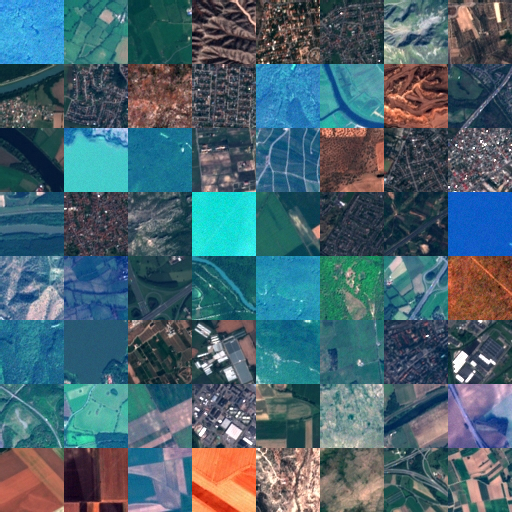

In [ ]:
get_concat_v_multi_blank(EX_images2)

## MODEL

MODEL PART: 
First of all a recap of variables,parameters: 



1.   IMAGE: 

      *  64 height 
      *  64 width 
      *  3 channels (r,g,b)

2.   LABELS: 10 classes
3.   x_train = 19440

so we need this informations to set the parameters in the model. 

The model is composed by 3 convolutional Blocks composed by: 


*   Batch-normalization layer: in order to accelerate the learning part. The batch normalization add also noise and hence is useful for limiting the overfitting.  
*   Convolutional layer: as starting filter I chose 16 and as kernel_size 5, the padding is 'same' in order to mantain the same size of the 'input'. The activation function is the relu. 
*   Subsamples layer: I chose a max pooling layer.

After these 3 convolutional layers, there is the fully connected part in order to obtain our predictions in terms of probability thank to the softmax function. I add also the dropout in order to limit again the overfitting with a prop_dropout = 0.5 and hence a prop_keep = 0.5. 

As parameter I chose batch-size = 32 and hence the iterations are = 19440/32 --> 608. And finally as epoch 20. 










In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

NUM_CLASSES = 10

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(filters=16, kernel_size=5, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [ ]:
EPOCHS = 20
early_stopping = tf.keras.callbacks.EarlyStopping(patience=7, min_delta=0.001, restore_best_weights=True)

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    validation_data=(X_eval,Y_eval),
    callbacks=[early_stopping]
)

Epoch 1/20
608/608 [==============================] - 185s 303ms/step - loss: 1.6062 - sparse_categorical_accuracy: 0.4460 - val_loss: 0.9868 - val_sparse_categorical_accuracy: 0.6678
Epoch 2/20
608/608 [==============================] - 177s 291ms/step - loss: 1.0743 - sparse_categorical_accuracy: 0.6433 - val_loss: 0.7433 - val_sparse_categorical_accuracy: 0.7517
Epoch 3/20
608/608 [==============================] - 181s 298ms/step - loss: 0.8805 - sparse_categorical_accuracy: 0.7149 - val_loss: 0.6723 - val_sparse_categorical_accuracy: 0.7798
Epoch 4/20
608/608 [==============================] - 183s 301ms/step - loss: 0.7473 - sparse_categorical_accuracy: 0.7630 - val_loss: 0.4860 - val_sparse_categorical_accuracy: 0.8461
Epoch 5/20
608/608 [==============================] - 184s 303ms/step - loss: 0.6453 - sparse_categorical_accuracy: 0.7980 - val_loss: 0.9086 - val_sparse_categorical_accuracy: 0.7761
Epoch 6/20
608/608 [==============================] - 186s 306ms/step - loss: 0.

In [ ]:
model.evaluate(x_test,y_test)

68/68 [==============================] - 5s 77ms/step - loss: 0.2965 - sparse_categorical_accuracy: 0.9120


[0.29651209712028503, 0.9120370149612427]

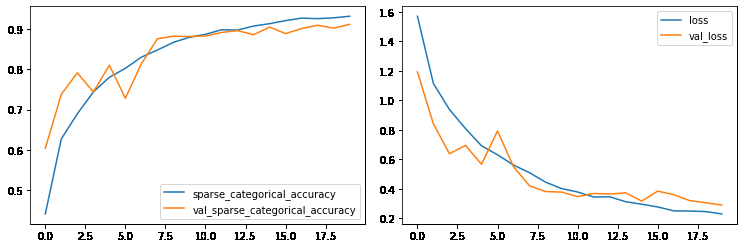

In [ ]:
'''import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()'''

path_im7 = '/content/drive/MyDrive/NN/history_graph.png'
path_im8 = '/content/drive/MyDrive/NN/History_graph2.png'
history_plot = get_concat_h(Image.open(path_im7),Image.open(path_im8))
history_plot =  history_plot.save("/content/drive/MyDrive/NN/history_plot.png")
Image.open("/content/drive/MyDrive/NN/history_plot.png")

In [ ]:
# model.save('/content/drive/MyDrive/NN/model_1.h5')

## LOAD THE MODEL

In [ ]:
path_model = "/content/drive/MyDrive/NN/model_3.h5"

In [ ]:
model = tf.keras.models.load_model(path_model)

## FGSM ATTACK 

For this part I chose to use the Cleverhans library.
It's an open-source library for benchmarking the vulnerability of machine learning models to adversarial examples.
It was created by Ian Goodfellow and Nicolas Papernot.
I chose to use directly the Github repository of the library because the current version doesn't support TF2 but on github there is already the code supporting TF2.

I used the Fast gradient sign method.
It's an adversarial attack that uses the gradient of the loss and it adjusts the inputs in order to maximize the loss.
In other words the original image x is manipulated by adding or subtracting a small error ϵ to each pixel.We add ϵ if the sign of the gradient for a pixel is positive otherwise we subtract ϵ .So we obtain that the image is intentionally altered to make the model classification fail.

In [ ]:
%%capture

!pip install -q tensorflow==2.0.0b1
!pip install git+https://github.com/tensorflow/cleverhans.git

import cleverhans
from cleverhans.tf2.attacks import fast_gradient_method

In [ ]:
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [ ]:
idx = np.random.randint(len(y_test))
Y_test = y_test[idx]
X_test = x_test[idx]

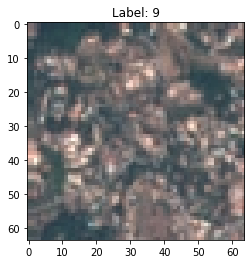

In [ ]:
import matplotlib.pyplot as plt 

original_image = X_test
original_image = tf.convert_to_tensor(original_image.reshape((1,64,64, 3))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = Y_test
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

#Show the image

plt.figure()
plt.grid(False)

plt.imshow(np.reshape(original_image, (64,64,3)))
plt.title("Label: {}".format(original_label[0]))

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


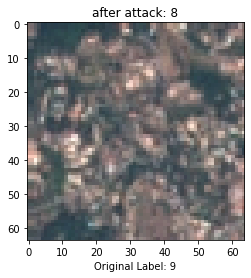

In [ ]:
epsilon = 0.005

adv_example_untargeted_label = fast_gradient_method.fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (64,64,3)))
plt.title("after attack: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

## ONE PIXEL ATTACK

In [ ]:
import matplotlib.pyplot as plt

Originally I've performed a pixel attack without any optimization, just changing a pixel in randomic way. 
I've decided to mantain this part of code exclusively in order to perform a first visualization about the perturbation of an image.

In [ ]:
def perturb_image2(img_id):
  x = np.random.randint(64)
  y = np.random.randint(64)
  r = np.random.uniform(0,1)
  g = np.random.uniform(0,1)
  b = np.random.uniform(0,1)
  image_perturbed = x_test[img_id].copy()
  image_perturbed[x,y,:] = [r,g,b]
  arr = [x,y,r,g,b]
  return image_perturbed,arr

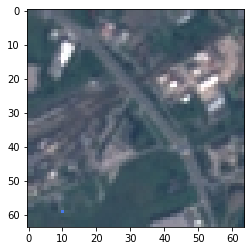

In [ ]:
plt.imshow(perturb_image2(70)[0])

The optimization of the attack is based on the Differential_evolution:[Differential_evolution on Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html). It's used for pixel attack because we have to tune x,y,r,g,b.  Each candidate solution is represented by a vector of real numbers (x,y,r,g,b) which are the inputs to the function we would like to minimize. It initializes the function with randomic value for our parameter. It's very useful the presence of bound that I set according to my values: 


*   X --> [0,64]
*   Y --> [0,64]
*   r --> [0,1]
*   g --> [0,1]
*   b --> [0,1]




In [ ]:
from scipy.optimize import differential_evolution

here we perturb the image, this function take as input 2 parameters: 


*   xs --> the array containing the 5 values: x,y,r,g,b. X and y represents the position of the pixel perturbed and r,g,b influence the color of that pixel. 
*   img --> is the numpy array representing the image that we have to perturb

And return the image perturbed



In [ ]:
def perturb_image(xs, img):
  xs = list(xs)
  x = int(xs[0])
  y = int(xs[1])
  r = xs[2]
  g = xs[3]
  b = xs[4]
  image_perturbed = img.copy()
  image_perturbed[x,y,:] = [r,g,b]
  return image_perturbed

This function take as input xs and img as before in order to perturb the image and return the predictions and so the confidence over the prediction. 

In [ ]:
def predict_classes(xs, img): #,target_class --> np.argmax(model.predict(img.reshape(1,64,64,3)))
  target_class = 1 
  imgs_perturbed = perturb_image(xs, img)
  predictions = model.predict(imgs_perturbed.reshape(1,64,64,3))[0][target_class]
  return predictions 

The principal aim of this function is to break the attack, because return True if the predicted class is different respect to the target class. 

In [ ]:
def attack_success(x, img): #,target_class --> np.argmax(model.predict(img.reshape(1,64,64,3)))
  target_class = 1 
  attack_image = perturb_image(xs,img)
  confidence = model.predict(attack_image.reshape(1,64,64,3))[0]
  predicted_class = np.argmax(confidence)
  if predicted_class != target_class:
    return True

The attack is very important because call the all the previous functions. In order to achieve the minimization over the prior confidence of the original prediction. I perform this minimization using the differential evolution algorithm. 

In [ ]:
def attack(img, maxiter=75, popsize=400):  #,target_class --> np.argmax(model.predict(img.reshape(1,64,64,3)))
    bounds = [(0,64), (0,64), (0,1), (0,1), (0,1)] 
    
    popmul = max(1, popsize // len(bounds))

    def predict_fn(xs):
        return predict_classes(xs,img)
    
    def callback_fn(x, convergence,):
        return attack_success(x,img)
    
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)
    
    attack_image = perturb_image(attack_result.x, img)


    return [attack_result.x]

In [ ]:
xs = [3,5,1,1,0]

In [ ]:
a = np.array(x_test[16])

In [ ]:
predict_classes(xs,a)

0.9410281

In [ ]:
res = attack(a)

In [ ]:
a_file = open("/content/drive/MyDrive/NN/array_16.txt", "w")
for row in res:
    np.savetxt(a_file, row)

a_file.close()

In [ ]:
original_array = np.loadtxt("/content/drive/MyDrive/NN/array_16.txt").reshape(1, 5)

In [ ]:
res = original_array

In [ ]:
res

array([[55.87382592, 16.10238158,  0.87804465,  0.54383893,  0.97526039]])

In [ ]:
res[0]

array([55.87382592, 16.10238158,  0.87804465,  0.54383893,  0.97526039])

In [ ]:
posterior = (model.predict(perturb_image(res[0],a).reshape(1,64,64,3)))
class_posterior = np.argmax(posterior)
prior = (model.predict(x_test[16].reshape(1,64,64,3)))
class_prior = np.argmax(prior)
p_posterior = round(posterior[0][class_posterior],2)
p_prior = round(prior[0][class_prior],2)


In [ ]:
p_posterior

1.0

In [ ]:
p_prior

0.94

Text(0.5, 0, 'with confidence: 0.9399999976158142')

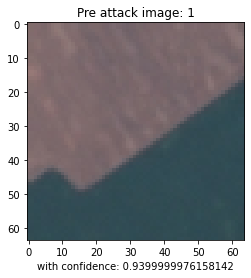

In [ ]:
plt.imshow(a)
plt.title(f'Pre attack image: {class_prior}')
plt.xlabel(f'with confidence: {p_prior}')
# plt.savefig('/content/drive/MyDrive/NN/PRE_ATTACK.png') #per non risalvarlo sempre

Text(0.5, 0, 'with confidence: 1.0')

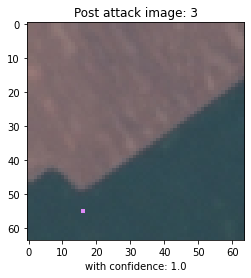

In [ ]:
plt.imshow(perturb_image(res[0],a))
plt.title(f'Post attack image: {class_posterior}')
plt.xlabel(f'with confidence: {p_posterior}')
#plt.savefig('/content/drive/MyDrive/NN/POST_ATTACK.png') 

In [ ]:
b = np.array(x_test[22])

In [ ]:
res2 = attack(b)

In [ ]:
b_file = open("/content/drive/MyDrive/NN/array_22.txt", "w")
for row in res2:
    np.savetxt(b_file, row)

b_file.close()

In [ ]:
original_array2 = np.loadtxt("/content/drive/MyDrive/NN/array_22.txt").reshape(1, 5)

In [ ]:
res = original_array2

In [ ]:
res2[0]

array([26.47608978, 52.2552787 ,  0.99763114,  0.9998207 ,  0.91714903])

In [ ]:
posterior2 = (model.predict(perturb_image(res2[0],b).reshape(1,64,64,3)))
class_posterior2 = np.argmax(posterior2)
prior2 = model.predict(x_test[22].reshape(1,64,64,3))
class_prior2 = np.argmax(prior2)
p_prior2 = prior2[0][class_prior2]
p_posterior2 = posterior2[0][class_posterior2]

In [ ]:
plt.imshow(b)
plt.title(f'Pre attack image: {class_prior2}')
plt.xlabel(f'with confidence: {p_prior2}')
# plt.savefig('/content/drive/MyDrive/NN/PRE_ATTACKbis.png') #per non risalvarlo sempre

In [ ]:
plt.imshow(perturb_image(res[0],b))
plt.title(f'Post attack image: {class_posterior2}')
plt.xlabel(f'with confidence: {p_posterior2}')
#plt.savefig('/content/drive/MyDrive/NN/POST_ATTACKbis.png') 

In [ ]:
import sys
from PIL import Image

path_im1 = '/content/drive/MyDrive/NN/PRE_ATTACK1.png'
path_im2 = '/content/drive/MyDrive/NN/POST_ATTACK1.png'

path_im3 = '/content/drive/MyDrive/NN/PRE_ATTACK2.png'
path_im4 = '/content/drive/MyDrive/NN/POST_ATTACK2.png'

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [ ]:
def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

In [ ]:
im_fin_1 = get_concat_h(Image.open(path_im1),Image.open(path_im2))

In [ ]:
im_fin_2 = get_concat_h(Image.open(path_im3),Image.open(path_im4))

In [ ]:
im_fin_1pa = get_concat_v(im_fin_1,im_fin_2)

In [ ]:
im_fin_1pa =  im_fin_1pa.save("/content/drive/MyDrive/NN/PLOT_FINALE_1PA.png")

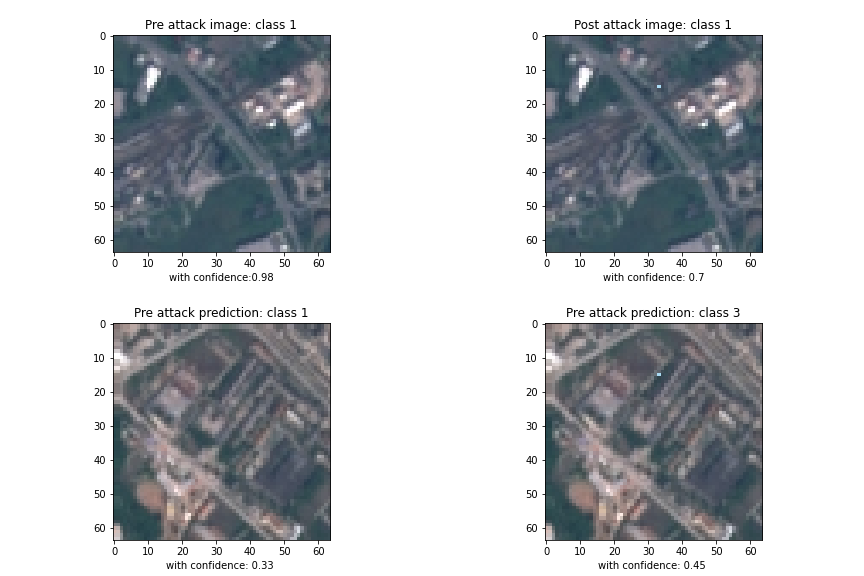

In [ ]:
Image.open("/content/drive/MyDrive/NN/PLOT_FINALE_1PA.png")